<a href="https://colab.research.google.com/github/lucasestrela/Dissertacao/blob/main/Calculando_Custo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Importanto Pacotes

In [1]:
!pip install statsmodels --upgrade

Requirement already up-to-date: statsmodels in /usr/local/lib/python3.7/dist-packages (0.12.2)


In [2]:
import numpy as np
import pandas as pd # Para manipular os dados
import warnings
from statsmodels.tsa.arima_model import ARMA # Versao antiga da fç
# from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.stattools import arma_order_select_ic
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

warnings.filterwarnings('ignore')

# 2) Definindo Funções

As funções abaixo se referem:

a) *calculate_best_arima()* : Calcula o melhor ARMA(p,q) para um dado *dataframe* e retorna a 1) tabela de regressão; 2) (p,q); 3) Os valores dos coeficientes AR e MA; 3) Variância do erro desta regressão;

b) *ma_infinite_representation2()* : Para um dado ARMA(p,q) faz a inversão para um MA($\infty$) truncado em T (grande);

c) *matriz_custo()* : Para um dado MA($\infty$), variância do erro, e grids do desconto intertemporal $\rho$ e aversão relativa ao risco $\gamma$, calcula o custo de bem estar

In [3]:
###################################################
############## --- Funcoes uteis --- ##############
###################################################


def calculate_best_arima(data_frame):
    # Seleciono o melhor (p,q) usando criterio de selecao Bayesiano
    # max (5, 5) provisoriamente
    res1 = arma_order_select_ic(data_frame,
                                max_ar = 3, max_ma = 4, 
                                ic = ['aic', 'bic'],
                                fit_kw={'method':'css-mle'},
                                trend = 'c'
                                )
    

    model_bic = ARMA(data_frame, 
                 order = (res1.bic_min_order[0], res1.bic_min_order[1])
                 )
    
    model_aic = ARMA(data_frame, 
                 order = (res1.aic_min_order[0], res1.aic_min_order[1])
                 )
    
    res_bic = model_bic.fit(transparams = False, 
                            disp=0
                            ) 
    
    res_aic = model_aic.fit(transparams = False, 
                            disp=0
                            ) 

    
    AR_bic, MA_bic = res_bic.arparams, res_bic.maparams
    AR_aic, MA_aic = res_aic.arparams, res_aic.maparams
    
    
    var_bic = sum( (data_frame - res_bic.predict())**2 )/(len(data_frame) - (len(AR_bic) + len(MA_bic) + 1) )
    var_aic = sum( (data_frame - res_aic.predict())**2 )/(len(data_frame) - (len(AR_aic) + len(MA_aic) + 1) )
    
    return res1.bic_min_order, res1.aic_min_order, AR_bic, MA_bic, AR_aic, MA_aic, var_bic, var_aic
    
    

def ma_infinite_representation2(AR, MA, T = 10000):

    Pol = np.zeros(T)
    
    if len(MA) == 0:
        MA = [0]
        
    if len(AR) == 0:
        AR = [0]
    
    
    # O que quero construir:
    Pol[0] = 1
    Pol[1] = MA[0] + AR[0]
    # Pol[2] = MA[1] + AR[1]*Pol[0] + AR[0]*Pol[1]
    # Pol[3] = MA[2] + AR[2]*Pol[0] + AR[1]*Pol[1] + AR[0]*Pol[2]
    # Pol[4] = MA[3] + AR[3]*Pol[0] + AR[2]*Pol[1] + AR[1]*Pol[2] + AR[0]*Pol[3]
    # Pol[5] = MA[4] + AR[4]*Pol[0] + AR[3]*Pol[1] + AR[2]*Pol[2] + AR[1]*Pol[3] + AR[0]*Pol[4]
        

    # Podem, pode surgir problema de dimensionalidade dos coeficientes
    # ex. ARMA(0,0) ou MA(1).. Entao completo as dimensões restantes
    # do ARMA como 0, ja que os coef são, de fato, zero.
    
    AR_teste = np.append(AR, np.zeros(T-len(AR)
                                      )
                         )
       
    MA_teste = np.append(MA, np.zeros(T-len(MA)
                                      )
                         )


    for i in range(2, T):
                  
        # Virando de tras pra frente
        AR_m = np.flip(AR_teste[0:i])
        
        # Calculando o iesimo termo
        Pol[i] = MA_teste[i - 1] + np.dot(Pol[0:i], AR_m)

    return Pol


def matriz_custo( MA_inf, var_u, Rho = np.array([0.05, 0.04, 0.03]), Gamma = np.array([1, 3, 5]), T = 10000):
    
    lambda_ARMA = np.zeros(
                          ( len(Rho),len(Gamma) )
                          )
    
    Exp = np.zeros(T)

    Acumulado = np.cumsum(MA_inf**2)
    Acumulado = np.cumsum(Acumulado)
    
    
    for i in range(0, len(Rho)):   
        for j in range(0, len(Gamma)):   
            for t in range(0, T):
                
                Exp[t] = np.exp(-Rho[i]*t)
                
        
            if Gamma[j] < 1.1:
                    
                Soma = np.dot(Exp, Acumulado)
                
                # Exp(1) no matlab retorna 2.7183. No numpy 2.718281828459045
                lambda_ARMA[i, j] = np.exp(0.5 * (var_u) * (1 - np.exp(-Rho[i]) ) * Soma) - 1
                 
                
            else:
                    
                Soma = np.exp(0.5 * (var_u) * Gamma[j] * (Gamma[j]-1) * Acumulado)
                parte = 1 + np.dot(Exp, Soma)
                lambda_ARMA[i, j] = np.exp( (np.log( (1-np.exp(-Rho[i])) * parte) ) / ( Gamma[j]-1 ) )  - 1
                                               

    return lambda_ARMA


Na última função, em particular, calculamos a seguinte somatória:


\begin{align*}
    \ln(1+\lambda) = 
        \begin{cases}
           \frac{1}{2} \sigma^2_u (1-e^\rho ) \Big(\sum^{\infty}_{t=1} e^{\rho t} \sum_{t-1}^{j=0} \alpha_i^2 \Big), \quad se \quad \gamma = 1 \\
           (\gamma - 1)^{-1} \ln \Big [ (1- e^{\rho}) (1+ \sum_{\infty}^{t=1} e^{\rho t} e^{0,5 \sigma^2_u \gamma (\gamma-1) \sum^{t-1}_{j=0} \sum^{j}_{i=0} \alpha_i^2}) \Big], \quad se \quad \gamma \neq 1
        \end{cases}
\end{align*}

## Custo do Obtsfeld (1984)

Neste paper, Obstfeld usa uma função de utilidade recursiva (Epstein-Zin) para calcular o custo do bem estar. O autor define $\tilde{\kappa} \big[ (\mu, \sigma_{z}^{2} ) ( \mu', \sigma_{z}^{2'} ); \gamma; \theta \big]$ como a variação equivalente do consumidor, isto é, o quanto que o consumidor estaria disposto a pagar para passar de uma sequência de consumo que possui $(\mu, \sigma_{z}^{2})$ de tendência e variância para $( \mu', \sigma_{z}^{2'} )$. Obtesfeld (1984) supõe que o consumo segue um passeio aleatório, isto é, um ARIMA(0,1,0) (pg. 4 do paper):

$$c_t = c_0 + (\mu - \frac{1}{2} \sigma_{\zeta}^2) + \sum^{t}_{i = 1} \zeta_i,$$

onde $Var( \sum^{t}_{i = 1} \zeta_i) = t \sigma_\zeta^2$. Portanto, supondo a fç utilidade EZ e um passeio aleatório no consumo, podemos calcular o equivalente certeza como (pg. 8 do paper):

$$\tilde{\kappa}\big[ (\mu, \sigma_{z}^{2} ) ( \mu', \sigma_{z}^{2'} ); \gamma; \theta \big] \approx \Big(-\frac{1}{2} \gamma \Delta \sigma^2_{\zeta}  + \Delta \mu \Big) \frac{\beta e^{(1-\theta)(\mu - \frac{1}{2} \gamma \Delta \sigma^2_{\zeta})} }{1-\beta e^{(1-\theta)(\mu -\frac{1}{2} \gamma \Delta \sigma^2_{\zeta})}}  $$

Note que $\lambda$ do custo calculado por Reis (2009) tem a mesma interpretação de $\tilde{\kappa} (\mu, \sigma_{z}^{2} ) ( \mu, 0 )$ neste caso. Logo, podemos reescrever a equação acima como:

$$\tilde{\kappa} \big[ (\mu, \sigma_{z}^{2} ) ( \mu, 0 ); \gamma; \theta \big]  \approx \Big(-\frac{1}{2} \gamma \sigma^2_{\zeta} \Big) \frac{\beta e^{(1-\theta)(\mu - \frac{1}{2} \gamma \sigma^2_{\zeta})} }{1-\beta e^{(1-\theta)(\mu -\frac{1}{2} \gamma \sigma^2_{\zeta})}} $$



In [4]:
# 1) Suponho que é um ARIMA(0,1,0) para todas as séries. Calculo a variancia do residuo.
# 2) Constante = mu - 1/2 sigma^2  ====> mu = constante + 1/2 sigma^2]
# 3) Calculo kappa

###### Passo 1

def calculate_arima010(data_frame):

    model = ARMA(data_frame, 
                 order = (0,0)
                 )
    
    res = model.fit(transparams = False, 
                    disp=0
                    ) 

    
    AR, MA = res.arparams, res.maparams
    
    var = sum( (data_frame - res.predict())**2 )/(len(data_frame) - (len(AR) + len(MA) + 1) )

    Mu = res.params[0] + 0.5*var
    
    return res, AR, MA, var, Mu



def matriz_custo_obsteld(Mu, var_u, Rho = np.array([0.05, 0.04, 0.03]), Gamma = np.array([1.1, 3, 5]), T = 10000):
    
    lambda_ARMA = np.zeros(
                          ( len(Rho),len(Gamma) )
                          )

    
    for i in range(0, len(Rho)):   
        for j in range(0, len(Gamma)):
            
             #Reis(2009, pg 5). Detalhado abaixo
             Beta = np.exp(-(Rho - (Theta + 1)*Mu))

             if Gamma[j] == 1:

                    
                # Pensar no que fazer. Eq. 11 do Obtsfeld fala que \theta \neq 1
                lambda_ARMA[i, j] = -np.inf
                 
                
             else:
                    
                numerador   = Beta * np.exp((1-Theta)*(Mu - 0.5* Gamma * var_u))
                denominador = 1 - numerador
                
                lambda_ARMA[i, j] = (-0.5 * Gamma * var_u) * (numerador/denominador)
                                               

    return lambda_ARMA

## Estranho !!

Para compatibilizar o desconto de Reis e Obtsfeld

Reis:
$$\sum_{t=0}^{\infty} e^{-\beta t} u (C_t)$$

Obtsfeld:
$$\sum_{t=0}^{\infty} \eta^{t} u (C_t)$$

Logo,

\begin{align*}
  e^{-\beta t} & = \eta^{t} && \Rightarrow \\
  -\beta & = \ln \eta && \Rightarrow \\
  e^{-\beta} & = \eta && \Rightarrow \\
\end{align*}

Reis define $\rho = \beta + (\gamma - 1)\mu$, logo, podemos escrever o desconto $\eta$ como função de $\rho$.

$$e^{-(\rho - (\gamma + 1)\mu)} = \eta$$

# 3) Importando Dados

Nesta seção utilizo dados da PWT 10.0

In [5]:
###################################################################
############## --- Abrindo Bases e Transformando --- ##############
###################################################################

# Abrindo a base
url = 'https://www.rug.nl/ggdc/docs/pwt100.xlsx'
pwt = pd.read_excel(url,
                    sheet_name = 'Data'
                    )


#Selecionando apenas as variaveis que vou utilizar
pwt = pwt[['country', 'countrycode', 'year', 'cgdpo','csh_c', 'pop']]

# Filtro os anos
pwt = pwt[pwt['year'] <= 2011]
pwt = pwt[pwt['year'] >= 1951]

# Crio variavel log do cons. percapita
pwt['cons_pcapta'] = np.log(pwt['cgdpo']*pwt['csh_c']/pwt['pop'])

countries = pwt['country'].unique()
country_codes = pwt['countrycode'].unique()

# 4) Calculando o custo

In [6]:
# Criando listas que armazenarão o output do modelo
best_ARMA     = [[None]* len(countries), [None]* len(countries)] 
lambda_ARMA   = [[None]* len(countries), [None]* len(countries)]

Rho_0   = np.arange(0.05, 0.03, -0.01)
Gamma_0 = np.arange(1, 6, 2)

In [7]:
for idx, country in enumerate(countries):
        
    try:
        #Eliminando NA e diferenciando
        newdf = pwt[(pwt['country'] == country) ].dropna()
        newdf = newdf['cons_pcapta'].diff().dropna()
    
        # Calculando o melhor ARMA
        best_ARMA[0][idx] , best_ARMA[1][idx] , AR_coef_bic, MA_coef_bic, AR_coef_aic, MA_coef_aic, variance_bic, variance_aic = calculate_best_arima(newdf)
    
        # best_ARMA[1][idx] , best_ARMA[1][idx] , AR_coef_bic, MA_coef_bic, AR_coef_aic, MA_coef_aic, variance_bic, variance_aic /= teste
    
    
        #Transformando MA(inf)
        Pol_bic = ma_infinite_representation2(
                                              AR = AR_coef_bic, 
                                              MA = MA_coef_bic
                                              )
        
        Pol_aic = ma_infinite_representation2(
                                              AR = AR_coef_aic, 
                                              MA = MA_coef_aic
                                              )
    
    
        #Calculando custo do ciclo
        lambda_ARMA[0][idx] = matriz_custo(
                                           MA_inf = Pol_bic, 
                                           var_u  = variance_bic,
                                           Rho    = Rho_0,
                                           Gamma  = Gamma_0
                                           )
        
        lambda_ARMA[1][idx] = matriz_custo(
                                           MA_inf = Pol_aic, 
                                           var_u  = variance_aic,
                                           Rho    = Rho_0,
                                           Gamma  = Gamma_0
                                           )
        
        print(f'[Num, País, Variance] = {idx:3} | {country:25}  | best_ARMA')
        
    except:
        print(f'[Num, País, Variance] = {idx:3} | {country:25}  | Não Inversível')

[Num, País, Variance] =   0 | Aruba                      | best_ARMA
[Num, País, Variance] =   1 | Angola                     | best_ARMA
[Num, País, Variance] =   2 | Anguilla                   | best_ARMA
[Num, País, Variance] =   3 | Albania                    | best_ARMA
[Num, País, Variance] =   4 | United Arab Emirates       | best_ARMA
[Num, País, Variance] =   5 | Argentina                  | best_ARMA
[Num, País, Variance] =   6 | Armenia                    | best_ARMA
[Num, País, Variance] =   7 | Antigua and Barbuda        | best_ARMA
[Num, País, Variance] =   8 | Australia                  | best_ARMA
[Num, País, Variance] =   9 | Austria                    | best_ARMA
[Num, País, Variance] =  10 | Azerbaijan                 | best_ARMA
[Num, País, Variance] =  11 | Burundi                    | best_ARMA
[Num, País, Variance] =  12 | Belgium                    | best_ARMA
[Num, País, Variance] =  13 | Benin                      | best_ARMA
[Num, País, Variance] =  14 | Burk

In [8]:
del idx, country, AR_coef_bic, MA_coef_bic, AR_coef_aic, MA_coef_aic, variance_bic, variance_aic, Pol_bic, Pol_aic

# 5) Exportando os dados

In [12]:
custo = [[None]* len(countries), [None]* len(countries)]

for idx in range(0, len(countries)):
    
    try:
      # Obtendo custo de (Rho, Gamma) = (0.04, 3)
        custo[0][idx] = lambda_ARMA[0][idx][1,1]*100
        custo[1][idx] = lambda_ARMA[1][idx][1,1]*100
        
    except:
        custo[0][idx] = None
        custo[1][idx] = None

custo = pd.DataFrame([custo[0][:], custo[1][:], country_codes]).T
custo.columns = ['custo_bic', 'custo_aic', 'countrycode']

In [13]:
# Exportanto dados

custo.to_csv('custos_data.csv')
files.download('custos_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 6) Graficos



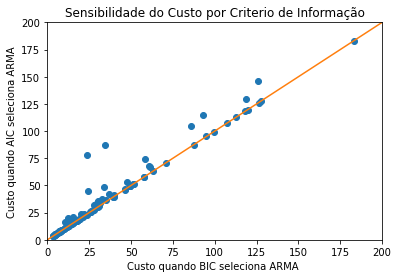

In [26]:
x = np.linspace(0, 200, 2)

plt.plot(custo['custo_bic'], custo['custo_aic'], 'o')
plt.plot(x, x)
plt.xlim(0,200)
plt.ylim(0,200)
plt.xlabel('Custo quando BIC seleciona ARMA ')
plt.ylabel('Custo quando AIC seleciona ARMA')
plt.title('Sensibilidade do Custo por Criterio de Informação')
plt.show()

### 6.1) Verificando sensibilidade do custo em $\gamma$ e $\rho$


In [29]:
np.set_printoptions(suppress=True)

country_list = ['Brazil', 'United States']
lambda_ARMA2 = [None]*len(country_list)

Rho_ = np.arange(0.05, 0.03, -0.001)
Gamma_ = np.arange(1, 5, 0.02)

for i_country, country in enumerate(country_list):
    #Eliminando NA e diferenciando
    newdf = pwt[(pwt['country'] == country) ].dropna()
    newdf = newdf['cons_pcapta'].diff().dropna()

    # Calculando o melhor ARMA
    best_ARMA2, best_ARMA2, AR_coef_bic, MA_coef_bic, AR_coef_aic, MA_coef_aic, variance_bic, variance_aic = calculate_best_arima(newdf)

    #Transformando MA(inf)
    Pol = ma_infinite_representation2(
                                      AR = AR_coef_bic, 
                                      MA = MA_coef_bic
                                      )

    lambda_ARMA2[i_country] = matriz_custo(
                                           MA_inf = Pol, 
                                           var_u = variance_bic,
                                           Rho = Rho_,
                                           Gamma = Gamma_
                                           )


# Matriz lambda_ARMA2:
# Linha  = Rho
# Coluna = Gamma

Note que o custo cresce exponencialmente em $\gamma$ e decresce em $\rho$

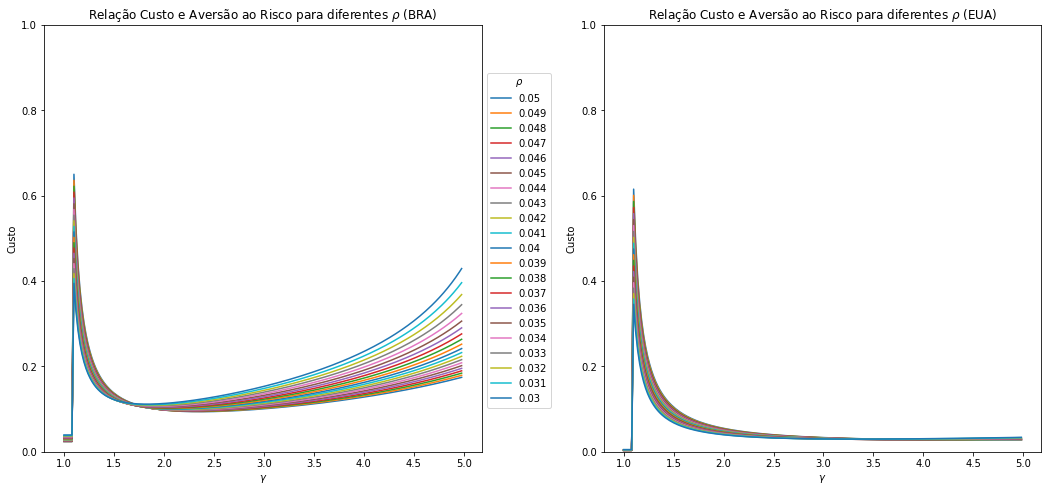

In [60]:
# Set up the matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(15, 7))

for i_rho, rhho in enumerate(Rho_):
    axes[0].plot( Gamma_, lambda_ARMA2[0][i_rho, :])    
    
    axes[0].legend(np.round(Rho_, 3), 
                   bbox_to_anchor=(1.0, 0.90),
                   title = r'$\rho$')



for i_rho, rhho in enumerate(Rho_):
    axes[1].plot( Gamma_, lambda_ARMA2[1][i_rho, :])


# Espaçamento entre as figuras
f.tight_layout(pad=3.0)

# Algumas configurações de cada gráfico
axes[0].set_ylim(0, 1)
axes[0].set_title('Relação Custo e Aversão ao Risco para diferentes ' + r'$\rho$' + ' (BRA)')
axes[0].set_xlabel(r'$\gamma$')
axes[0].set_ylabel("Custo")

axes[1].set_ylim(0, 1)
axes[1].set_title('Relação Custo e Aversão ao Risco para diferentes ' + r'$\rho$' + ' (EUA)')
axes[1].set_xlabel(r'$\gamma$')
axes[1].set_ylabel("Custo")

plt.show()


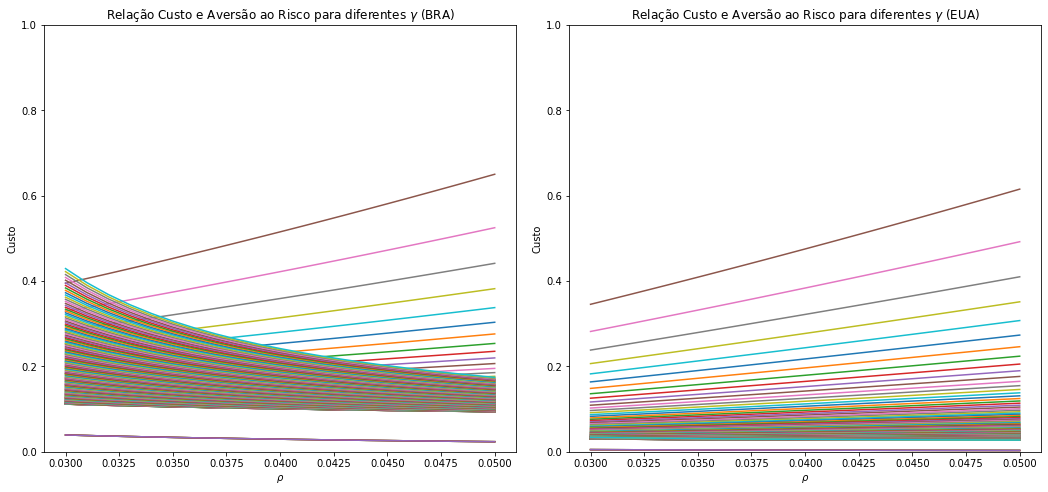

In [63]:
# Set up the matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(15, 7))


for i_gamma, gama in enumerate(Gamma_):
    axes[0].plot( Rho_ , lambda_ARMA2[0][:, i_gamma])


for i_gamma, gama in enumerate(Gamma_):
    axes[1].plot( Rho_ , lambda_ARMA2[1][:, i_gamma])


# Espaçamento entre as figuras
f.tight_layout(pad=3.0)

# Algumas configurações de cada gráfico
axes[0].set_ylim(0, 1)
axes[0].set_title('Relação Custo e Aversão ao Risco para diferentes ' + r'$\gamma$' + ' (BRA)')
axes[0].set_xlabel(r'$\rho$')
axes[0].set_ylabel("Custo")

axes[1].set_ylim(0, 1)
axes[1].set_title('Relação Custo e Aversão ao Risco para diferentes ' + r'$\gamma$' + ' (EUA)')
axes[1].set_xlabel(r'$\rho$')
axes[1].set_ylabel("Custo")

plt.show()

### 6.2) Plotando os melhores ARMAS

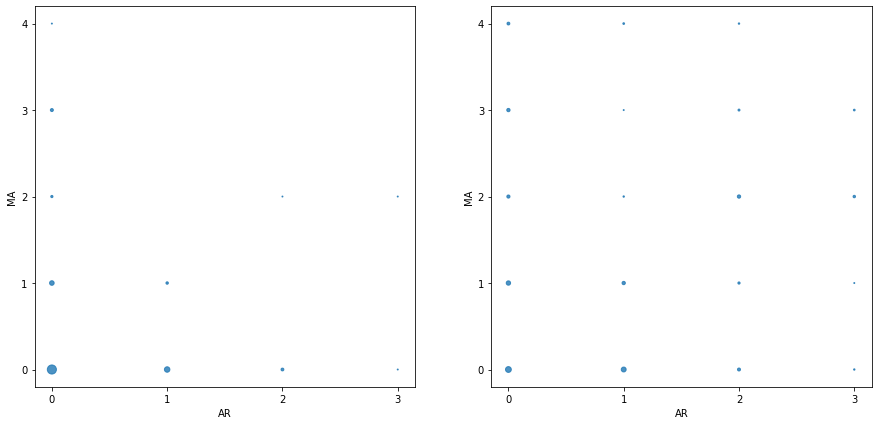



Quantidade de ARMA utilizando o critério BIC
(0, 0)    83
(1, 0)    30
(0, 1)    21
(0, 3)     9
(2, 0)     8
(1, 1)     6
(0, 2)     5
(3, 0)     1
(2, 2)     1
(0, 4)     1
(3, 2)     1
Name: Count, dtype: int64

################################################

Quantidade de ARMA utilizando o critério AIC
(0, 0)    34
(1, 0)    24
(0, 1)    19
(0, 3)    11
(2, 2)    11
(1, 1)    11
(0, 2)    10
(2, 0)     9
(0, 4)     8
(3, 2)     6
(2, 1)     5
(2, 3)     4
(1, 4)     3
(3, 3)     3
(3, 0)     2
(2, 4)     2
(1, 2)     2
(3, 1)     1
(1, 3)     1
Name: Count, dtype: int64


In [81]:
# Selecionando os melhores ARMA mas excluindo os paises que nao sao inversiveis
best_ARMA_bic = [x for x in best_ARMA[0][:] if x is not None]
best_ARMA_aic = [x for x in best_ARMA[1][:] if x is not None]

# Total de modelos na respectiva especificação
Vetor_bic = pd.DataFrame({'Count':best_ARMA_bic})
Vetor_aic = pd.DataFrame({'Count':best_ARMA_aic})

Vetor_bic = pd.DataFrame(Vetor_bic['Count'].value_counts())
Vetor_aic = pd.DataFrame(Vetor_aic['Count'].value_counts())

# Transformando o DF para obter uma coluna da ordem do MA e outra do AR
Vetor_bic['AR'] = pd.DataFrame([AR[0] for AR in Vetor_bic.index], index = Vetor_bic.index)
Vetor_bic['MA'] = pd.DataFrame([MA[1] for MA in Vetor_bic.index], index = Vetor_bic.index)


Vetor_aic['AR'] = pd.DataFrame([AR[0] for AR in Vetor_aic.index], index = Vetor_aic.index)
Vetor_aic['MA'] = pd.DataFrame([MA[1] for MA in Vetor_aic.index], index = Vetor_aic.index)



# Plotando o grafico
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

ax[0].scatter(x = Vetor_bic['AR'], y = Vetor_bic['MA'], s = Vetor_bic['Count'], alpha=0.8)
ax[0].set(
          xlabel='AR',
          ylabel='MA'
          )
ax[0].set_xticks([0, 1, 2, 3])
ax[0].set_yticks([0, 1, 2, 3, 4])


ax[1].scatter(x = Vetor_aic['AR'], y = Vetor_aic['MA'], s = Vetor_aic['Count'], alpha=0.8)
ax[1].set(
          xlabel='AR',
          ylabel='MA'
          )
ax[1].set_xticks([0, 1, 2, 3])
ax[1].set_yticks([0, 1, 2, 3, 4])
plt.show()

print()
print()
print('Quantidade de ARMA utilizando o critério BIC')
print(Vetor_bic.iloc[:, 0])
print()
print('################################################')
print()
print('Quantidade de ARMA utilizando o critério AIC')
print(Vetor_aic.iloc[:, 0])

### 6.3) Plotando o histograma dos custos

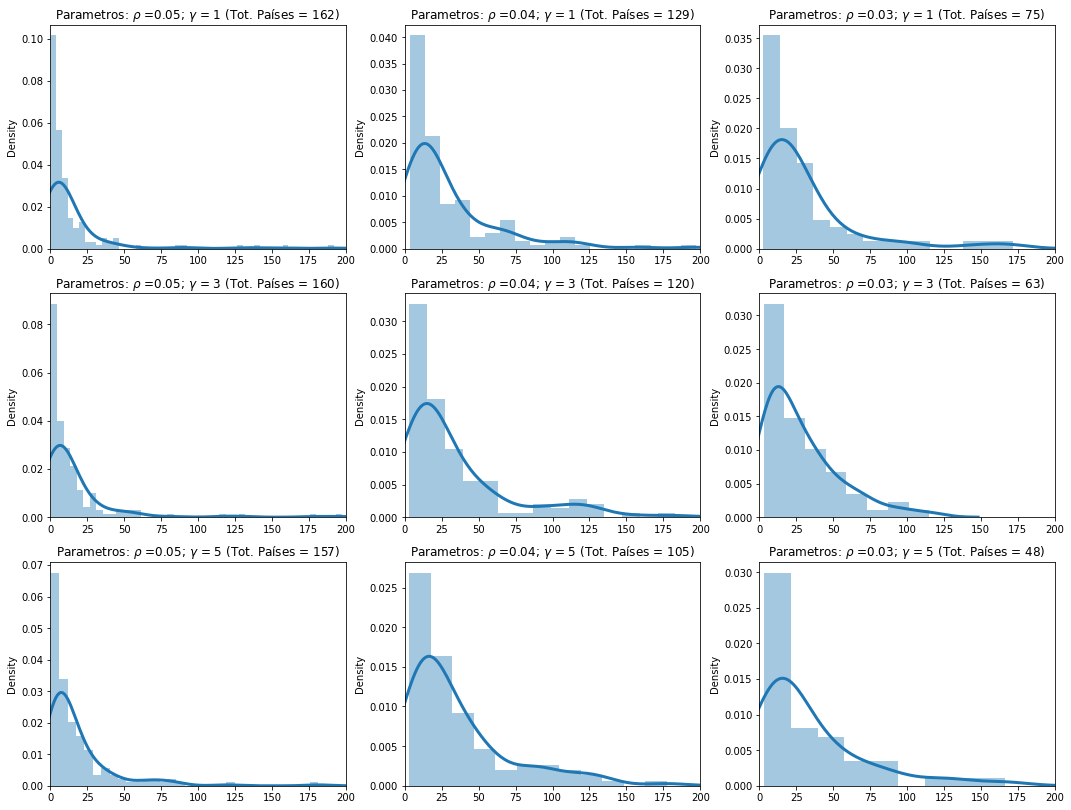

In [119]:
# Plotando o grafico
fig, axes = plt.subplots(3, 3, figsize=(18, 14))

custo = [None] * len(countries)
    
for j, rhho in enumerate(Rho_0):
    for i, gama in enumerate(Gamma_0):
        
        custo = [None] * len(countries)
        
        for idx in range(0, len(countries)):
            
            try:
                custo[idx] = lambda_ARMA[0][idx][i,j]*100
                
            except:
                custo[idx] = None
        
        custo = pd.DataFrame(custo)
        
        #Removo os custos acima de 100%
        custo = custo[custo < 200]  
        
        # Label do Histograma = Tupla de parametros
        lab = 'Parametros: ' + r'$\rho$ =' + str(np.round(rhho, 3)) + '; ' + r'$\gamma$ = ' + str(np.round(gama, 3)) + ' (Tot. Países = ' +str(custo[0].notnull().sum())+ ')' 


        # Densidade 2
        sns.distplot(custo, hist = True, kde = True,
                      kde_kws = {'linewidth': 3},
                      ax=axes[i,j]
                     )
        
        
        axes[i,j].set_xlim(0, 200)
        axes[i,j].set_title(lab)

# Espaçamento entre as figuras
f.tight_layout(pad = 5.0)


del j, i, idx